In [1]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config
input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)
import numpy as np
import pandas as pd

from sumo_python.helpers.generate_od_xml import generate_od_xml
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

df_gt_data = run_ground_truth_and_parse(config, sim_setup)


od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

In [2]:
import os
import math
from dataclasses import dataclass

import torch
from botorch.acquisition import qExpectedImprovement
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Ackley
from botorch.utils.transforms import unnormalize
from botorch.utils.transforms import normalize
from torch.quasirandom import SobolEngine

import gpytorch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import HorseshoePrior

from botorch.models.transforms import Standardize


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

## Maintain the TuRBO state

https://proceedings.neurips.cc/paper/2019/file/6c990b7aca7bc7058f5e98ea909e924b-Paper.pdf

TuRBO needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc.

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation.

Note: These settings assume that the domain has been scaled to [0,1]𝑑
 and that the same batch size is used for each iteration.

In [3]:
@dataclass
class TurboState:
    dim: int
    batch_size: int
    length: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0
    success_tolerance: int = 3  # Note: The original paper uses 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size])
        )


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

# Generate new batch

Given the current state and a probabilistic (GP) model built from observations X and Y, we generate a new batch of points.

This method works on the domain [0,1]𝑑
, so make sure to not pass in observations from the true domain. unnormalize is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the acqf argument.

In [4]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size,
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = qExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

# Optimization loop

This simple loop runs one instance of TuRBO-1 with Thompson sampling until convergence.

TuRBO-1 is a local optimizer that can be used for a fixed evaluation budget in a multi-start fashion. Once TuRBO converges, state["restart_triggered"] will be set to true and the run should be aborted. If you want to run more evaluations with TuRBO, you simply generate a new set of initial points and then keep generating batches until convergence or when the evaluation budget has been exceeded. It's important to note that evaluations from previous instances are discarded when TuRBO restarts.

NOTE: We use a SingleTaskGP with a noise constraint to keep the noise from getting too large as the problem is noise-free.

In [5]:
import numpy as np
import pandas as pd
def objective(x: np.array) -> pd.DataFrame:
    """Compute objective variable. This is the NRMSE loss between ground-truth output
    and the output of the simulation output evaluated at x.

    Args:
        x (np.array): Numpy array of counts to generate TAZ file from.

    Returns:
        pd.Dataframe: Data frame of sampling locations and loss esimate.
    """
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

In [6]:
import os
import torch

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds


tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Initial sampling locations

In [7]:
df_0 = pd.read_csv('./data/initial_sampling_locations.csv')

### Run loop

In [13]:
batch_size = 1
dim=4
state = TurboState(dim, batch_size)

SMOKE_TEST  = False
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky

torch.manual_seed(0)

### Run loop
NITER = 100
output = [df_0]
best_value = []


for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -1.0 * torch.from_numpy(df_[["loss_estimate"]].values) 
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Update state
    state = update_state(state=state, Y_next=train_Y)

    # Fit a GP model
    #train_Y = (Y_turbo - Y_turbo.mean()) / Y_turbo.std()
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
    covar_module = ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
        MaternKernel(
            nu=2.5, ard_num_dims=dim, lengthscale_constraint=Interval(0.005, 4.0)
        )
    )
    model = SingleTaskGP(
        train_X_norm, train_Y, 
        covar_module=covar_module, likelihood=likelihood, 
        outcome_transform=Standardize(m=1)
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # Do the fitting and acquisition function optimization inside the Cholesky context
    with gpytorch.settings.max_cholesky_size(max_cholesky_size):
        # Fit the model
        fit_gpytorch_mll(mll)

        # Create a batch
        new_x_turbo = generate_batch(
            state=state,
            model=model,
            X=train_X_norm,
            Y=train_Y,
            batch_size=batch_size,
            n_candidates=N_CANDIDATES,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
            acqf="ei", # "ts"
        )

    new_x = unnormalize(new_x_turbo,bounds)

    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)

    # Print current status
    print(
        f"Best value: {state.best_value:.2e}, TR length: {state.length:.2e}"
    )

####### 1 ########
##### n=20 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~111875.00UPS, vehicles TOT 3176 ACT 895 BUF 25)        
Best value: -2.70e-02, TR length: 8.00e-01
####### 2 ########
##### n=21 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~93750.00UPS, vehicles TOT 3017 ACT 750 BUF 0)          
Best value: -2.70e-02, TR length: 8.00e-01
####### 3 ########
##### n=22 #####
##### best_value=-0.027004666207663 #####
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7m

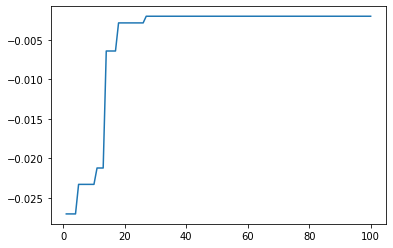

,x1,x2,x3,x4,loss_estimate,iter
0,734.995399,640.217550,866.129964,761.451422,0.006422,13
0,736.736187,645.180225,864.715903,740.993884,0.002872,17
0,753.019248,629.284839,846.976718,754.988371,0.009970,20
0,757.164276,638.737549,875.142706,751.502189,0.003211,22
0,695.606617,639.316537,892.843405,716.568514,0.009014,24
...,...,...,...,...,...,...
0,714.869388,637.904703,877.984464,740.905626,0.002031,96
0,714.869531,637.904729,877.984468,740.905584,0.002031,97
0,714.869482,637.904662,877.984441,740.905495,0.002031,98
0,714.869386,637.904786,877.984524,740.905549,0.002031,99


In [14]:
df_plot = df_i.query('iter>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()
df_i.query('loss_estimate<0.010')

In [15]:
df_i.to_csv("./data/turbo_ei.csv",index = None)